# Bayesian Classification

**Author:** Filip Kołodziejczyk

## Theoretical introduction

$D = \{(x_i, y_i) : i = 1, 2, ..., n\}$ - training set  
$x_i = (x_{i1}, x_{i2}, ..., x_{ip})$ - p-dimensional feature vector  
$y_i \in \{0, 1\}$ - binary class label (problem can be generalized to multi-class classification)  
$x_0$ - new feature vector to be classified  

### Bayes' theorem
$$P(y_i =1 | x_i) = \frac{P(x_i | y_i = 1)P(y_i = 1)}{P(x_i)} = \frac{P(x_i | y_i = 1)P(y_i = 1)}{\sum_{k=0}^{1} P(x_i | y_i = k)P(y_i = k)}$$
$P(y_i = 1)$ - prior probability (of class 1)  
$P(x_i | y_i = 1)$ - likelihood  
$P(x_i)$ - evidence probability  
$P(y_i =1 | x_i)$ - posterior probability

### LDA (Linear Discriminant Analysis) Assumptions
- $P(x_i | y_i = k) \sim N(\mu_k, \Sigma)$
- Sample is independent and identically distributed (i.i.d.)
- $\Sigma$ is the same for all classes

### QDA (Quadratic Discriminant Analysis) Assumptions
- $P(x_i | y_i = k) \sim N(\mu_k, \Sigma_k)$
- Sample is independent and identically distributed (i.i.d.)
- $\Sigma_k$ is different for each class

### Naive Bayes Assumptions
- $P(x_i | y_i = k) \sim N(\mu_{ik}, \sigma_{ik}^2)$
- Sample is independent and identically distributed (i.i.d.)
- Features are statistically independent of each other

## Prerequisites

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import requests

# Setting the fixed random seed for reproducibility
np.random.seed(2024)

## Task 1: Implementation


### Instruction

Implementation (from scratch) of LDA, QDA and NB (Naive Bayes) methods for binary classifcation (classes 0 and 1):
- Create three classes in Python: LDA, QDA, NB
- Each class should have three methods:
    - Method fit(X,y), where X is a design matrix, containing in each row the values of features for  single observation and y is a vector containing values of binary target variable for observations. This method fits the model using training data. In the case of LDA, QDA and NB training the model includes estimation of the parameters (vectors of means, covariance matrices, prior probabilities).
    - Method predict_proba(Xtest) which computes predicted posterior probabilities for class 1 for observations whose feature values are in rows of the matrix Xtest.
    - Method predict(Xtest) which assigns the predicted class (0 or 1) for observations whose feature values are in rows of the matrix Xtest.
    - Method get_params that returns a list containing the estimated parameters

### Abstract base class for all classifiers

In [2]:
from abc import ABC, abstractmethod

class Bayesian_Classifier(ABC):
    """Bayesian Classifier for binary classification {0, 1}"""
    @abstractmethod
    def fit(self, training_data: np.matrix, training_labels: np.array) -> None:
        """Fit the model to the training data"""
        pass

    @abstractmethod
    def predict(self, test_data: np.matrix) -> np.array:
        """Predict the classification of the test data"""
        pass

    @abstractmethod
    def predict_proba(self, test_data: np.matrix) -> np.array:
        """Predict the probability of the test data to be in class 1"""
        pass

    @abstractmethod
    def get_params(self) -> dict:
        """Return the parameters of the model"""
        pass

### Linear Discriminant Analysis Classifier Class

In [3]:
class LDA(Bayesian_Classifier):
    """Linear Discriminant Analysis (LDA) classifier for binary classification {0,1}."""
    def __init__(self):
        self.discriminant: np.array = None
        self.mean_0: np.array = None
        self.mean_1: np.array = None

    def fit(self, training_data: np.matrix, classification: np.array) -> None:
        class_0 = training_data[classification == 0]
        class_1 = training_data[classification == 1]

        mean_0 = np.mean(class_0, axis=0)
        mean_1 = np.mean(class_1, axis=0)
        mean_diff = mean_1 - mean_0

        # Within-class scatter matrix
        S_W = np.dot((class_0 - mean_0).T, (class_0 - mean_0)) + \
            np.dot((class_1 - mean_1).T, (class_1 - mean_1))

        # Between-class scatter matrix
        # mean = np.mean(training_data, axis=0)
        # S_B = class_0.shape[0] * np.outer(mean_0 - mean, mean_0 - mean) + \
        #     class_1.shape[0] * np.outer(mean_1 - mean, mean_1 - mean)
        # eigvals, eigvecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
        # eigvecs = eigvecs[:, np.argsort(-eigvals)]
        # self.discriminant = eigvecs[:, 0]

        # Following calculation is more efficient
        self.discriminant = np.dot(np.linalg.inv(S_W), mean_diff)

        self.mean_0 = mean_0
        self.mean_1 = mean_1

    def predict_proba(self, test_data: np.matrix) -> np.array:
        a = np.dot(test_data, self.discriminant) - 0.5 * np.dot(self.mean_0 + self.mean_1, self.discriminant)
        return 1 / (1 + np.exp(-a))
    
    def predict(self, test_data: np.matrix) -> np.array:
        return np.where(self.predict_proba(test_data) >= 0.5, 1, 0)

    def get_params(self) -> dict:
        return {"discriminant": self.discriminant}

### Quadratic Discriminant Analysis Classifier Class

In [4]:
class QDA(Bayesian_Classifier):
    """Quadratic Discriminant Analysis (QDA) classifier for binary classification {0,1}."""

    def __init__(self, reg_param: float = 1e-6):
        self.mean_0: np.array = None
        self.mean_1: np.array = None
        self.inv_cov_0: np.array = None
        self.inv_cov_1: np.array = None
        self.prior_0: float = None
        self.prior_1: float = None
        self.reg_param: float = reg_param

    def fit(self, training_data: np.matrix, classification: np.array) -> None:
        class_0 = training_data[classification == 0]
        class_1 = training_data[classification == 1]

        self.mean_0 = np.mean(class_0, axis=0)
        self.mean_1 = np.mean(class_1, axis=0)
        self.inv_cov_0 = np.linalg.inv(np.cov(class_0, rowvar=False) + self.reg_param * np.eye(class_0.shape[1]))
        self.inv_cov_1 = np.linalg.inv(np.cov(class_1, rowvar=False) + self.reg_param * np.eye(class_1.shape[1]))
        self.prior_0 = class_0.shape[0] / training_data.shape[0]
        self.prior_1 = class_1.shape[0] / training_data.shape[0]

    def predict_proba(self, test_data: np.matrix) -> np.array:
        prob_0 = np.apply_along_axis(
            self._prob, 1, test_data, self.mean_0, self.inv_cov_0, self.prior_0
        )
        prob_1 = np.apply_along_axis(
            self._prob, 1, test_data, self.mean_1, self.inv_cov_1, self.prior_1
        )

        return prob_1 / (prob_0 + prob_1 + self.reg_param)

    def predict(self, test_data: np.matrix) -> np.array:
        return np.where(self.predict_proba(test_data) >= 0.5, 1, 0)

    def get_params(self) -> dict:
        return {
            "mean_0": self.mean_0,
            "mean_1": self.mean_1,
            "cov_0": np.linalg.inv(self.inv_cov_0),
            "cov_1": np.linalg.inv(self.inv_cov_1),
            "prior_0": self.prior_0,
            "prior_1": self.prior_1,
        }

    def _prob(self, x: np.array, mean: np.array, inv_cov: np.array, prior: float) -> float:
        return (
            prior
            * (1 / np.sqrt(np.linalg.det(2 * np.pi * inv_cov)))
            * np.exp(-0.5 * (x - mean).T.dot(inv_cov).dot(x - mean))
        )

### Naive Bayes Classifier Class

In [5]:
class NB(Bayesian_Classifier):
    """Naive Bayes (NB) classifier for binary classification {0,1}."""

    def __init__(self, reg_param: float = 1e-8):
        self.mean_0 = None
        self.mean_1 = None
        self.var_0 = None
        self.var_1 = None
        self.prior_0 = None
        self.prior_1 = None
        self.reg_param = reg_param

    def fit(self, training_data: np.matrix, classification: np.array) -> None:
        class_0 = training_data[classification == 0]
        class_1 = training_data[classification == 1]

        self.mean_0 = np.mean(class_0, axis=0)
        self.mean_1 = np.mean(class_1, axis=0)
        self.var_0 = np.var(class_0, axis=0)
        self.var_1 = np.var(class_1, axis=0)
        self.prior_0 = class_0.shape[0] / training_data.shape[0]
        self.prior_1 = class_1.shape[0] / training_data.shape[0]

    def predict_proba(self, test_data: np.matrix) -> np.array:
        prob_0 = np.prod(self._prob(test_data, self.mean_0, self.var_0), axis=1) * self.prior_0
        prob_1 = np.prod(self._prob(test_data, self.mean_1, self.var_1), axis=1) * self.prior_1

        return prob_1 / (prob_0 + prob_1 + self.reg_param)

    def predict(self, test_data: np.matrix) -> np.array:
        return np.where(self.predict_proba(test_data) >= 0.5, 1, 0)
    
    def get_params(self) -> dict:
        return {
            "mean_0": self.mean_0,
            "mean_1": self.mean_1,
            "var_0": self.var_0,
            "var_1": self.var_1,
            "prior_0": self.prior_0,
            "prior_1": self.prior_1,
        }

    def _prob(self, x: np.array, mean: np.array, var: np.array) -> float:
        adjusted_var = var + self.reg_param
        return (1 / np.sqrt(2 * np.pi * adjusted_var)) * np.exp(-0.5 * ((x - mean) ** 2) / adjusted_var)

## Task 2: Simulated data tests

### Instruction

There are two parameters which will vary in experiments: a and ρ. Generate training and testing data in the following way.
- Scheme 1: Each dataset contain n = 1000 observations, p = 2 features and a binary variable that is generated from the Bernoulli distribution with probability of success 0.5. Features of the observations from the class 0 are generated independently from a normal standard distribution (mean 0, variance 1). Features of the observations from the class 1 are generated independently from a normal distribution (mean a, variance 1). LDA assumptions are satisfied.
- Scheme 2: Each dataset contain n = 1000 observations, p = 2 features and a binary variable that is generated from the Bernoulli distribution with probability of success 0.5. Features of the observations from the class 0 are generated from a two-dimensional normal distribution (mean 0, variance 1, correlation ρ). Features of the observations from the class 1 are generated from a two-dimensional normal distribution (mean a, variance 1, correlation −ρ). LDA assumptions are not satisfied.

### Utility functions

In [6]:
def generate_data(
    scheme: int, n: int, p: int, a: float = 1, rho: float = 0.5
) -> tuple[np.array, np.array]:
    """Generate synthetic data for binary classification"""
    classification = np.random.choice([0, 1], size=n, p=[0.5, 0.5])
    features = np.zeros((n, p))

    # Generate features for each class
    for i in range(n):
        if classification[i] == 0:
            if scheme == 1:
                features[i] = np.random.normal(0, 1, p)
            elif scheme == 2:
                cov = np.eye(p) * (1 - rho) + rho
                features[i] = np.random.multivariate_normal(np.zeros(p), cov)
        else:
            if scheme == 1:
                features[i] = np.random.normal(a, 1, p)
            elif scheme == 2:
                cov = np.eye(p) * (1 + rho) - rho
                features[i] = np.random.multivariate_normal(np.full(p, a), cov)

    return np.array(features), classification


def evaluate_model(
    model: Bayesian_Classifier,
    X_train: np.matrix,
    y_train: np.array,
    X_test: np.matrix,
    y_test: np.array,
) -> float:
    """Evaluate the model using the test data"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return np.mean(y_pred == y_test)

### Task 2.1

Compare LDA, QDA, and NB for both schemes (compute accuracy on the testing set) for fixed value ρ = 0.5 and diffrent values of a = 0.1, 0.5, 1, 2, 3, 5. Repeat the experiment for diffrent train/test splits and generate boxplots showing the values of accuracy for each method and each value of the parameter a. Save the results in the file BayesianSimulatedData1.pdf

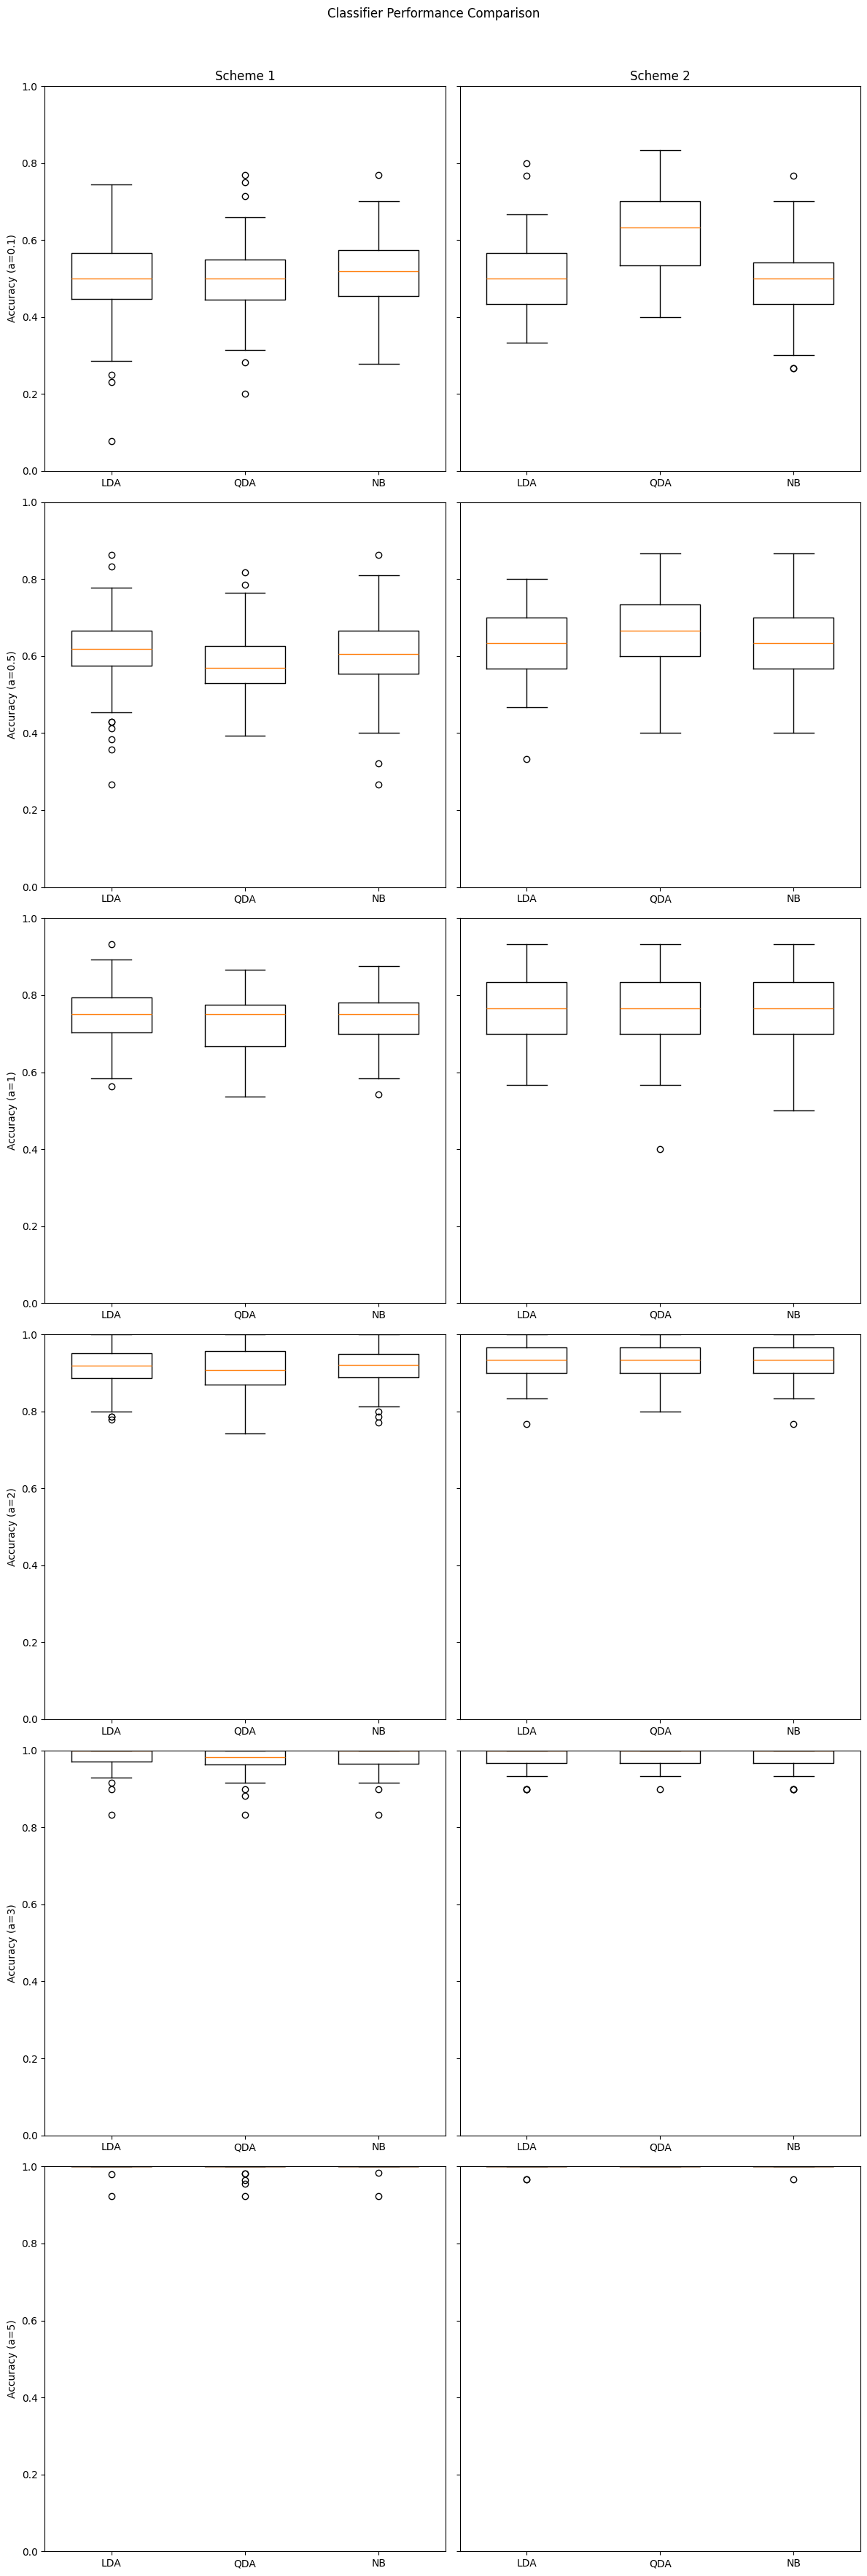

In [7]:
n = 100
p = 2
a = [0.1, 0.5, 1, 2, 3, 5]
rho = 0.5
num_simulations = 100
filename = "BayesianSimulatedData1.pdf"

lda = LDA()
qda = QDA()
nb = NB()

results_scheme1 = {a: {"LDA": [], "QDA": [], "NB": []} for a in a}
results_scheme2 = {a: {"LDA": [], "QDA": [], "NB": []} for a in a}

# Simulation
for a_ in a:
    for _ in range(num_simulations):
        X, y = generate_data(1, n, p, a_, rho=rho)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(0.1, 0.6))

        for model, name in zip([lda, qda, nb], ["LDA", "QDA", "NB"]):
            accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
            results_scheme1[a_][name].append(accuracy)

        X, y = generate_data(2, n, p, a_, rho=rho)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        for model, name in zip([lda, qda, nb], ["LDA", "QDA", "NB"]):
            accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
            results_scheme2[a_][name].append(accuracy)


# Plotting the results and saving to PDF
fig, ax = plt.subplots(len(a), 2, figsize=(12, 6 * len(a)), sharey=True)

for i, a_ in enumerate(a):
    for j, (results, title) in enumerate(
        zip([results_scheme1, results_scheme2], ["Scheme 1", "Scheme 2"])
    ):
        lda_accuracies = results[a_]["LDA"]
        qda_accuracies = results[a_]["QDA"]
        nb_accuracies = results[a_]["NB"]

        # Boxplot for each classifier
        ax[i, j].boxplot(lda_accuracies, positions=[1], widths=0.6)
        ax[i, j].boxplot(qda_accuracies, positions=[2], widths=0.6)
        ax[i, j].boxplot(nb_accuracies, positions=[3], widths=0.6)

        if i == 0:
            ax[i, j].set_title(title)
        if j == 0:
            ax[i, j].set_ylabel(f"Accuracy (a={a_})")
        ax[i, j].set_xticks([1, 2, 3])
        ax[i, j].set_xticklabels(["LDA", "QDA", "NB"])
        ax[i, j].set_ylim(0, 1)

fig.suptitle("Classifier Performance Comparison")
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(filename)
plt.show()

### Task 2.2

Compare LDA, QDA, and NB for both schemes (compute accuracy on the testing set) for fixed value a = 2 and diffrent values of ρ = 0, 0.1, 0.3, 0.5, 0.7, 0.9. Repeat the experiment for diffrent train/test splits and generate boxplots showing the values of accuracy for each method and each value of the parameter ρ. Save the results in the file BayesianSimulatedData2.pdf

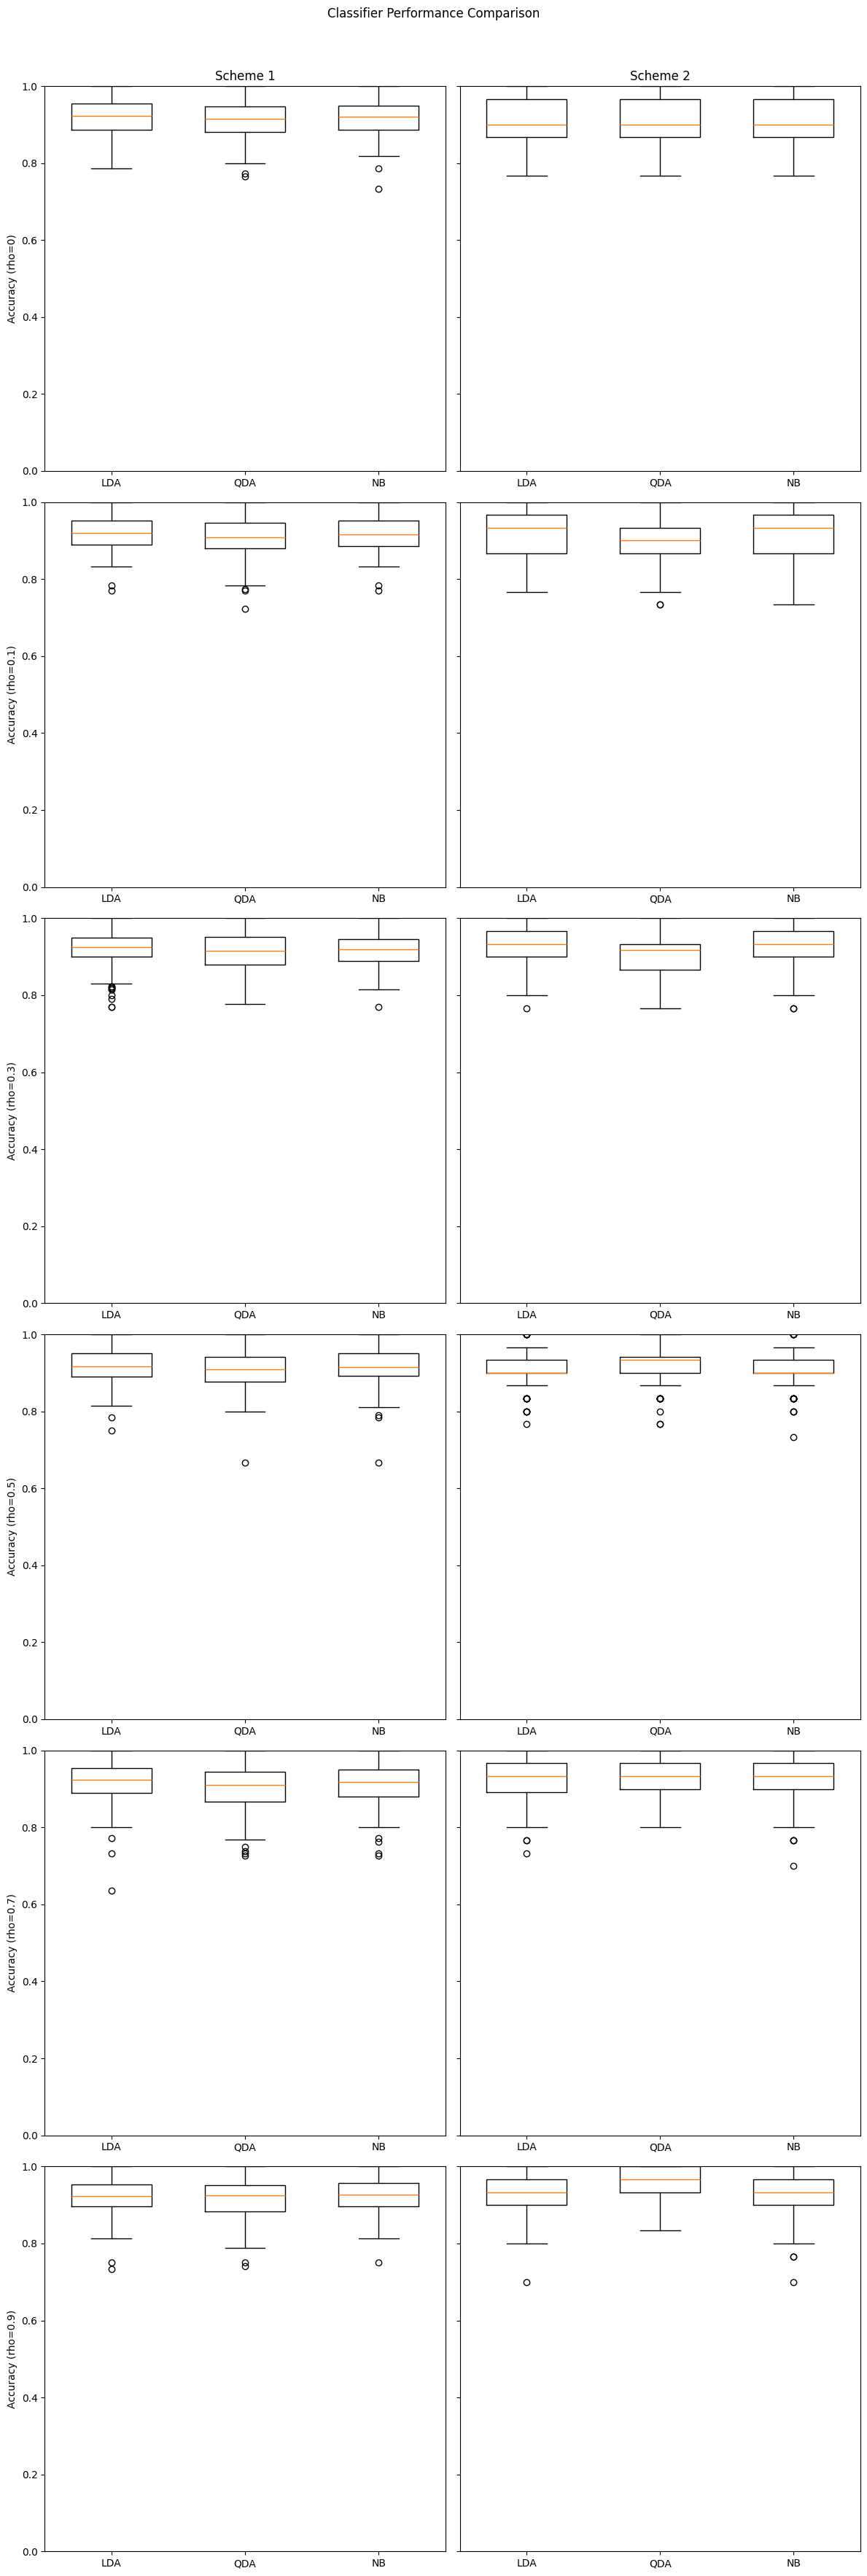

In [8]:
n = 100
p = 2
a = 2
rho = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
num_simulations = 100
filename = "BayesianSimulatedData2.pdf"

lda = LDA()
qda = QDA()
nb = NB()

results_scheme1 = {rho: {"LDA": [], "QDA": [], "NB": []} for rho in rho}
results_scheme2 = {rho: {"LDA": [], "QDA": [], "NB": []} for rho in rho}

# Simulation
for rho_ in rho:
    for _ in range(num_simulations):
        X, y = generate_data(1, n, p, a, rho=rho_)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(0.1, 0.6))

        for model, name in zip([lda, qda, nb], ["LDA", "QDA", "NB"]):
            accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
            results_scheme1[rho_][name].append(accuracy)

        X, y = generate_data(2, n, p, a, rho=rho_)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        for model, name in zip([lda, qda, nb], ["LDA", "QDA", "NB"]):
            accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
            results_scheme2[rho_][name].append(accuracy)


# Plotting the results and saving to PDF
fig, ax = plt.subplots(len(rho), 2, figsize=(12, 6 * len(rho)), sharey=True)

for i, rho_ in enumerate(rho):
    for j, (results, title) in enumerate(
        zip([results_scheme1, results_scheme2], ["Scheme 1", "Scheme 2"])
    ):
        lda_accuracies = results[rho_]["LDA"]
        qda_accuracies = results[rho_]["QDA"]
        nb_accuracies = results[rho_]["NB"]

        # Boxplot for each classifier
        ax[i, j].boxplot(lda_accuracies, positions=[1], widths=0.6)
        ax[i, j].boxplot(qda_accuracies, positions=[2], widths=0.6)
        ax[i, j].boxplot(nb_accuracies, positions=[3], widths=0.6)

        if i == 0:
            ax[i, j].set_title(title)
        if j == 0:
            ax[i, j].set_ylabel(f"Accuracy (rho={rho_})")
        ax[i, j].set_xticks([1, 2, 3])
        ax[i, j].set_xticklabels(["LDA", "QDA", "NB"])
        ax[i, j].set_ylim(0, 1)

fig.suptitle("Classifier Performance Comparison")
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(filename)
plt.show()

### Task 2.3

For one chosen setting of parameters (e.g. a = 2, ρ = 0.5) generate a scatter plot showing observations from training set. Mark observations belonging to diffrent classes using two diffrent colors and two diffrent symbols. Draw curves that separate classes for LDA and QDA. Save the results in the file BayesianSimulatedData3.pdf

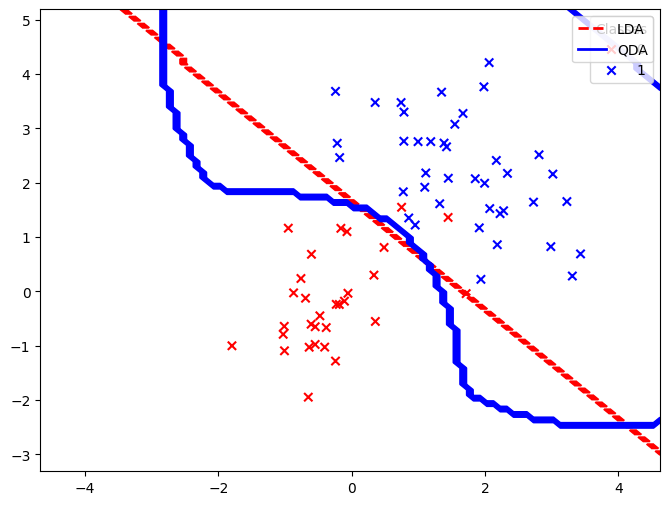

In [9]:
a = 2
rho = 0.5
n = 100
p = 2
filename = "BayesianSimulatedData3.pdf"

X, y = generate_data(2, n, p, a, rho=rho)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

lda = LDA()
qda = QDA()
lda.fit(X_train, y_train)
qda.fit(X_train, y_train)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

fig, ax = plt.subplots(figsize=(8, 6))

# LDA
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
lda_contour = ax.contour(xx, yy, Z, colors='r', linestyles='dashed')

# QDA
Z = qda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
qda_contour = ax.contour(xx, yy, Z, colors='b')

scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=ListedColormap(['#FF0000', '#0000FF']), marker='x')

# Create legend
legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend1)

# Create proxy artists for contour plots
lda_line = Line2D([0], [0], color='r', linestyle='dashed', lw=2)
qda_line = Line2D([0], [0], color='b', lw=2)
ax.legend([lda_line, qda_line], ['LDA', 'QDA'], loc='upper right')

plt.savefig(filename)
plt.show()

## Task 3: Real data tests

### Instruction

- Choose 3 datasets which are available on e.g., UCI repository https://archive.ics.uci.edu/ml/index.php or OpenML repository https://www.openml.org/ related to binary classification problem. Please only focus on datasets with numerical features.
- Compare LDA, QDA, and NB. Split data into training set and test set. Train the model on the train set and compute accuracy on the test set. Repeat the experiment for diffrent train/test splits and generate boxplots showing the values of accuracy for each method. Save the results for three datasets in the file BayesianReal.pdf

### Task 3.1 Data loading

In [10]:
dataset1_url = "https://www.openml.org/data/download/1586225/php0iVrYT.arff"
dataset2_url = "https://www.openml.org/data/download/1592318/phpAmSP4g"
dataset3_url = "https://www.openml.org/data/download/1592286/phpGUrE90"

# Download the datasets
response = requests.get(dataset1_url)
with open("blood-transfusion-service-center.arff", "wb") as file:
    file.write(response.content)

response = requests.get(dataset2_url)
with open("kr-vs-kp.arff", "wb") as file:
    file.write(response.content)

response = requests.get(dataset3_url)
with open("qsar-biodeg.arff", "wb") as file:
    file.write(response.content)

from scipy.io import arff
import pandas as pd

# Load the datasets
df1 = pd.DataFrame(arff.loadarff("blood-transfusion-service-center.arff")[0])
X1 = df1.drop(columns="Class").to_numpy()
y1 = (df1["Class"] == b'2').astype(int).to_numpy()

df2 = pd.DataFrame(arff.loadarff("kr-vs-kp.arff")[0])
X2 = df2.drop(columns="Class").to_numpy()
y2 = (df2["Class"] ==  b'2').astype(int).to_numpy()

df3 = pd.DataFrame(arff.loadarff("qsar-biodeg.arff")[0])
X3 = df3.drop(columns="Class").to_numpy()
y3 = (df3["Class"] ==  b'2').astype(int).to_numpy()

### Task 3.2 Comparing LDA, QDA, and NB

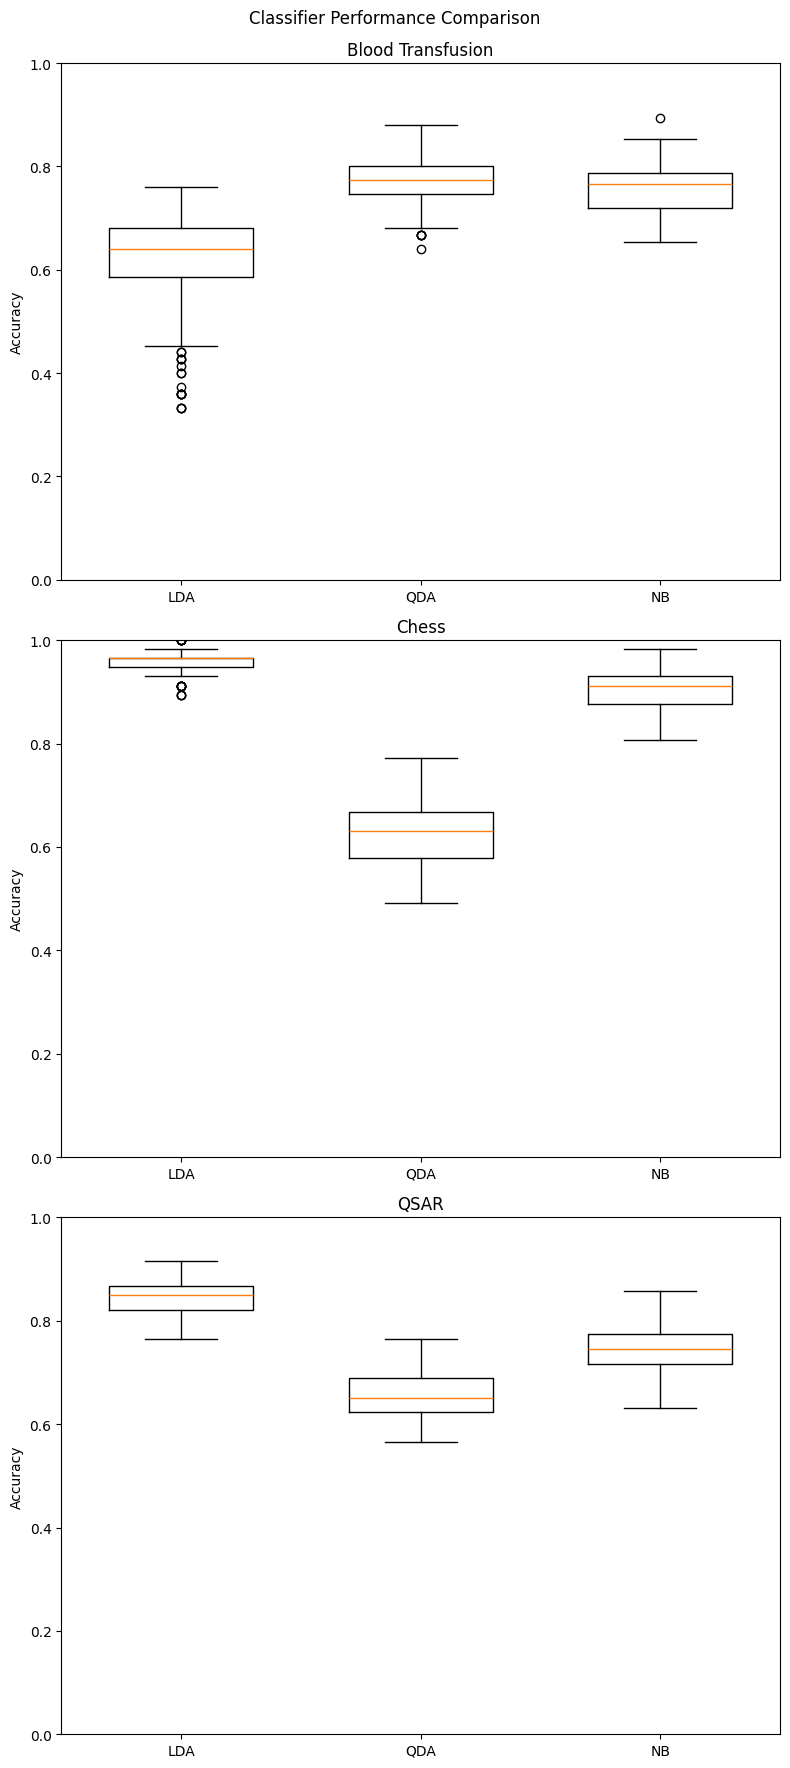

In [12]:
num_simulations = 100
filename = "BayesianReal.pdf"

lda = LDA()
qda = QDA()
nb = NB()

results = {dataset: {"LDA": [], "QDA": [], "NB": []} for dataset in ["Blood", "Chess", "QSAR"]}

for _ in range(num_simulations):
    test_size = 0.1

    for X, y, dataset in zip([X1, X2, X3], [y1, y2, y3], ["Blood", "Chess", "QSAR"]):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        for model, name in zip([lda, qda, nb], ["LDA", "QDA", "NB"]):
            accuracy = evaluate_model(model, X_train, y_train, X_test, y_test)
            results[dataset][name].append(accuracy)

# Plotting the results and saving to PDF
fig, ax = plt.subplots(3, 1, figsize=(8, 18), sharey=True)

for i, (dataset, title) in enumerate(zip(["Blood", "Chess", "QSAR"], ["Blood Transfusion", "Chess", "QSAR"])):
    lda_accuracies = results[dataset]["LDA"]
    qda_accuracies = results[dataset]["QDA"]
    nb_accuracies = results[dataset]["NB"]

    # Boxplot for each classifier
    ax[i].boxplot(lda_accuracies, positions=[1], widths=0.6)
    ax[i].boxplot(qda_accuracies, positions=[2], widths=0.6)
    ax[i].boxplot(nb_accuracies, positions=[3], widths=0.6)

    ax[i].set_title(title)
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xticks([1, 2, 3])
    ax[i].set_xticklabels(["LDA", "QDA", "NB"])
    ax[i].set_ylim(0, 1)

fig.suptitle("Classifier Performance Comparison")
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(filename)
plt.show()